# 0. Setup

In [222]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.spatial import distance
import datetime 
import matplotlib.pyplot as plt
import matplotlib.dates as dt
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [223]:
df = pd.read_csv('/content/drive/MyDrive/Colab_Projects/AML_final_project/data_geo_hos.csv')
df.head()

,hosp_yn,death_yn,sex_female,age_0,age_18,age_50,age_65,race_native,race_asian,race_black,race_other,race_native_pacific,race_white,ethnicity_hispanic,case_month,state_fips_code,county_fips_code,case_onset_interval,symptom_status,used_bed_ratio,used_icu_ratio
0,False,False,True,False,True,False,False,False,True,False,False,False,False,True,2021-02,34,34003,0,True,0.718141,0.451212
1,False,False,True,False,True,False,False,False,False,False,True,False,False,True,2021-02,51,51700,0,True,0.746529,0.774469
2,False,False,True,False,True,False,False,False,False,False,False,False,True,True,2021-02,51,51540,0,True,0.866410,0.755197
3,False,False,True,False,True,False,False,False,False,False,False,False,True,True,2020-08,36,36013,0,True,0.761232,0.659091
4,False,False,True,False,True,False,False,False,False,False,False,False,True,True,2020-12,39,39023,0,True,0.660607,0.855514


# 1. Demographic Comparison between Dataset and overall US Population

## 1.1. Age

In [224]:
# generate age distribution from dataset
N = len(df)
age_0_data  = len(df[df['age_0']])/N
age_18_data = len(df[df['age_18']])/N
age_50_data = len(df[df['age_50']])/N
age_65_data = len(df[df['age_65']])/N
data_ages = 100*np.array([age_0_data, age_18_data, age_50_data, age_65_data])

In [225]:
# copy age distribution from United States Census Bureau '2019gender_table1.xlsx' table
# https://www.census.gov/data/tables/2019/demo/age-and-sex/2019-age-sex-composition.html (table 1)
age_0_census  = 0.251 - 0.064*(2/5)
age_18_census = 0.395 + 0.064*(2/5)
age_50_census = 0.191
age_65_census = 0.164
census_ages = 100*np.array([age_0_census, age_18_census, age_50_census, age_65_census])

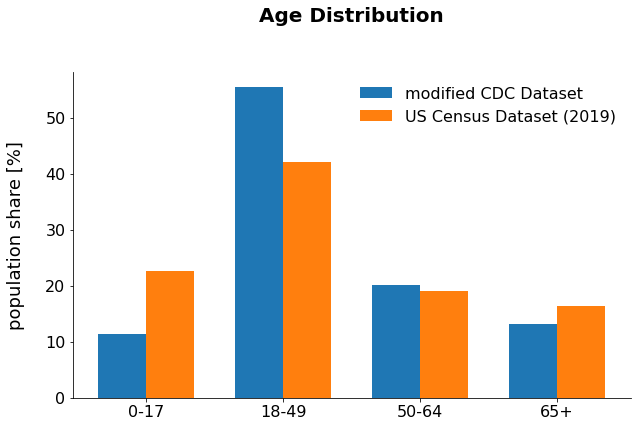

In [226]:
# plotting distributions
labels = ['0-17', '18-49', '50-64', '65+']

x = np.arange(len(labels))  
width = 0.35 

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, data_ages, width, label='modified CDC Dataset')
rects2 = ax.bar(x + width/2, census_ages, width, label='US Census Dataset (2019)')

ax.set_ylabel('population share [%]', fontsize = 18, labelpad = 20)
ax.set_title('Age Distribution\n\n', fontsize = 20, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize = 16)
ax.legend(frameon = False, fontsize = 16)
ax.tick_params(axis='y', which='major', labelsize=16)

top_side = ax.spines["top"]
top_side.set_visible(False)

right_side = ax.spines["right"]
right_side.set_visible(False)

plt.show()

## 1.2. Sex

Now we want to investigate the sex distribution in our dataset. Specifically, we will perform a binomial test (https://en.wikipedia.org/wiki/Binomial_test) to test wether the sex ratio in our dataset differs significantly from the overall population.

In [227]:
# calculate probability for female sex from UN population data 
# https://population.un.org/wpp/Download/Standard/Population/ (Total Population - Male/ Total Population - Female)
p_0 = 166238618/(162826299 + 166238618)
print('probability for female sex in overall US population: ', p_0)

probability for female sex in overall US population:  0.5051848720779918


In [228]:
#calculate total number of females in dataset
F = len(df[df['sex_female']])
print('probability for female sex in modified CDC dataset: ', F/N)

probability for female sex in modified CDC dataset:  0.5462200526361549


In [229]:
# perform binomial test
p_value = stats.binom_test(F, n=N, p=p_0, alternative='greater')
print('p-value: ', p_value)

p-value:  0.0


Since we have $p\approx0$ for our one-sided binomial test, we get $p<\alpha := 0.05$. We conclude that the female-to-male ratio in our dataset is significantly higher than the female-to-male ratio in the overall population. 

## 1.3. Race

In [230]:
# calculate race distribution
native_data         = len(df[df['race_native']])/N
asian_data          = len(df[df['race_asian']])/N
black_data          = len(df[df['race_black']])/N
other_data          = len(df[df['race_other']])/N
native_pacific_data = len(df[df['race_native_pacific']])/N
white_data          = len(df[df['race_white']])/N
data_races = 100*np.array([white_data, black_data, asian_data, native_data, native_pacific_data, other_data])

In [231]:
# copy race distribution from US census data
# https://en.wikipedia.org/wiki/Race_and_ethnicity_in_the_United_States (table: '2019 U.S. Census Bureau Estimates')
native_census         = 0.013
asian_census          = 0.059
black_census          = 0.134
other_census          = 0.028
native_pacific_census = 0.002
white_census          = 0.603 + 0.185
census_races = 100*np.array([white_census, black_census, asian_census, native_census, native_pacific_census, other_census])

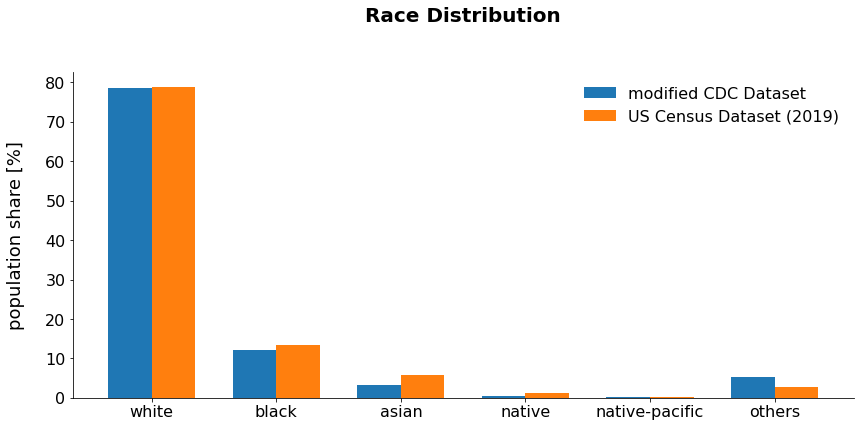

In [232]:
# plotting distributions
labels = ['white', 'black', 'asian', 'native', 'native-pacific', 'others']

x = np.arange(len(labels))  
width = 0.35 

fig, ax = plt.subplots(figsize=(14,6))
rects1 = ax.bar(x - width/2, data_races, width, label='modified CDC Dataset')
rects2 = ax.bar(x + width/2, census_races, width, label='US Census Dataset (2019)')

ax.set_ylabel('population share [%]', fontsize = 18, labelpad = 20)
ax.set_title('Race Distribution\n\n', fontsize = 20, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize = 16)
ax.legend(frameon=False, fontsize = 16)
ax.tick_params(axis='y', which='major', labelsize=16)

top_side = ax.spines["top"]
top_side.set_visible(False)

right_side = ax.spines["right"]
right_side.set_visible(False)

plt.show()

# 2. Hospitalization and Fatality Rate by Age

In [233]:
# calculating hospitalization rate by age
HR_age_0_data  = len(df[df['age_0'] & df['hosp_yn']])/len(df[df['age_0']])
HR_age_18_data = len(df[df['age_18'] & df['hosp_yn']])/len(df[df['age_18']])
HR_age_50_data = len(df[df['age_50'] & df['hosp_yn']])/len(df[df['age_50']])
HR_age_65_data = len(df[df['age_65'] & df['hosp_yn']])/len(df[df['age_65']])
data_HR = 100*np.array([HR_age_0_data, HR_age_18_data, HR_age_50_data, HR_age_65_data])

In [234]:
# calculating fatality rate by age
FR_age_0_data  = len(df[df['age_0'] & df['death_yn']])/len(df[df['age_0']])
FR_age_18_data = len(df[df['age_18'] & df['death_yn']])/len(df[df['age_18']])
FR_age_50_data = len(df[df['age_50'] & df['death_yn']])/len(df[df['age_50']])
FR_age_65_data = len(df[df['age_65'] & df['death_yn']])/len(df[df['age_65']])
data_FR = 100*np.array([FR_age_0_data, FR_age_18_data, FR_age_50_data, FR_age_65_data])

In [235]:
# CDC estimated infection fatality ratio 
# https://www.cdc.gov/coronavirus/2019-ncov/hcp/planning-scenarios.html (Table 1, Scenario 5)
IFR_age_0  = 20./1000000. 
IFR_age_18 = 500./1000000.
IFR_age_50 = 6000./1000000.
IFR_age_65 = 90000./1000000.
data_IFR = 100*np.array([IFR_age_0, IFR_age_18, IFR_age_50, IFR_age_65])

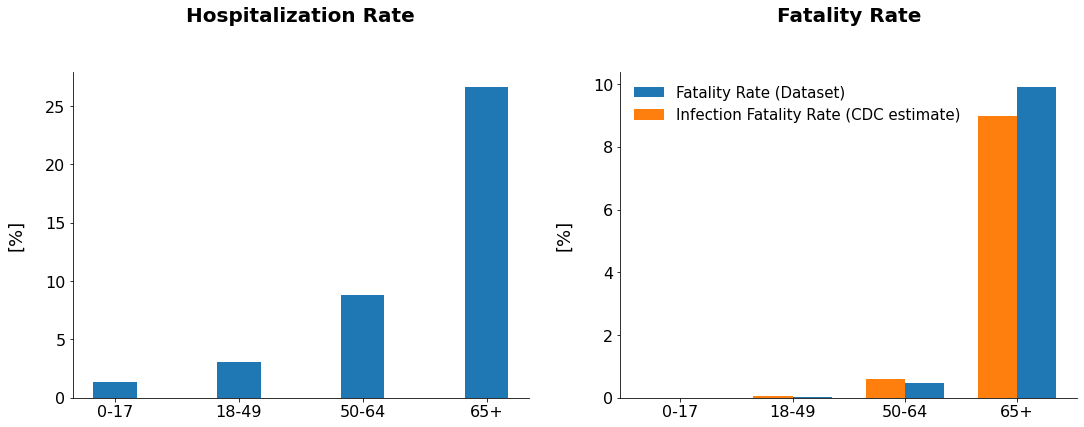

In [236]:
# plotting distributions
labels = ['0-17', '18-49', '50-64', '65+']

x = np.arange(len(labels))  
width = 0.35

fig, ax = plt.subplots(1,2, figsize=(18,6))

ax[0].bar(x, data_HR, width)
ax[0].set_ylabel('[%]', fontsize = 18, labelpad = 20)
ax[0].set_title('Hospitalization Rate\n\n', fontsize = 20, fontweight='bold')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels, fontsize = 16)
ax[0].tick_params(axis='y', which='major', labelsize=16)
top_side = ax[0].spines["top"]
top_side.set_visible(False)
right_side = ax[0].spines["right"]
right_side.set_visible(False)


ax[1].bar(x + width/2, data_FR, width, label='Fatality Rate (Dataset)')
ax[1].bar(x - width/2, data_IFR, width, label='Infection Fatality Rate (CDC estimate)')
ax[1].set_ylabel('[%]', fontsize = 18, labelpad = 20)
ax[1].set_title('Fatality Rate\n\n', fontsize = 20, fontweight='bold')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels, fontsize = 16)
ax[1].legend(frameon = False, fontsize = 15)
ax[1].tick_params(axis='y', which='major', labelsize=16)
top_side = ax[1].spines["top"]
top_side.set_visible(False)
right_side = ax[1].spines["right"]
right_side.set_visible(False)

plt.show()

# 3. Investigating Correlations with Hospitalization- and Fatality Rate



## 3.1. Jaccard Index

In [237]:
# inserting male column to calculate jaccard index
df.insert(2, 'sex_male', ~df.sex_female)

In [238]:
df_x = df.loc[:,'sex_male':'race_white']
df_y = df.loc[:,'hosp_yn':'death_yn']

# calculate jaccard distance
J_dist = np.empty((len(df_x.columns), len(df_y.columns)) )
for i, column_x in enumerate(df_x.columns):
  for j, column_y in enumerate(df_y.columns):
    J_dist[i][j] = distance.jaccard(df_x[column_x], df_y[column_y])

# calculate jaccard index
J_sim = 1 - J_dist

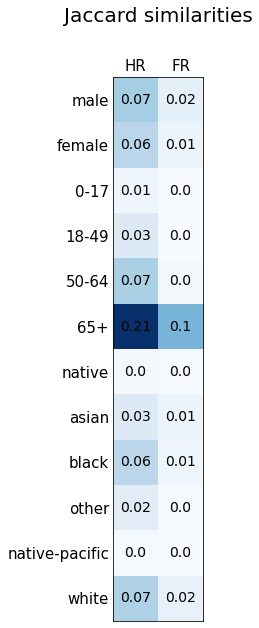

In [239]:
# plot jaccard index
labels_x = ['HR', 'FR']
labels_y = ['male', 'female', '0-17', '18-49', '50-64', '65+', 'native', 'asian', 'black', 'other', 'native-pacific', 'white']
x = np.arange(len(labels_x))
y = np.arange(len(labels_y))

fig, ax = plt.subplots(figsize = (10,10))
ax.matshow(J_sim, cmap=plt.cm.Blues)
ax.set_title('Jaccard similarities\n', fontsize = 20)
ax.tick_params(axis=u'both', which=u'both',length=0)

ax.set_xticks(x)
ax.set_xticklabels(labels_x, fontsize = 15)
ax.set_yticks(y)
ax.set_yticklabels(labels_y, fontsize = 15)

for i in range(J_sim.shape[0]):
    for j in range(J_sim.shape[1]):
        c = round(J_sim[i][j], 2)
        ax.text(j, i, str(c), va='center', ha='center', fontsize = 14)

## 3.2 Point-Biserial Correlation Coefficient

In [240]:
df_bed = df.loc[:,'used_bed_ratio':'used_icu_ratio']

# calculate point-biserial correlation coefficient
r_pb = np.empty((len(df_bed.columns), len(df_y.columns)))
p_pb = np.empty((len(df_bed.columns), len(df_y.columns)))
for i, column_bed in enumerate(df_bed.columns):
  for j, column_y in enumerate(df_y.columns):
    r_pb[i][j], p_pb[i][j] = stats.pointbiserialr(df_bed[column_bed], df_y[column_y])

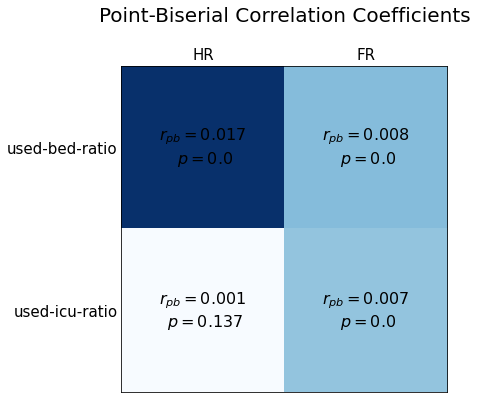

In [241]:
# plot point-biserial correlation coefficients
labels_x = ['HR', 'FR']
labels_y = ['used-bed-ratio', 'used-icu-ratio']
x = np.arange(len(labels_x))
y = np.arange(len(labels_y))

fig, ax = plt.subplots(figsize = (6,6))
ax.matshow(r_pb, cmap=plt.cm.Blues)
ax.set_title('Point-Biserial Correlation Coefficients\n', fontsize = 20)
ax.tick_params(axis=u'both', which=u'both',length=0)

ax.set_xticks(x)
ax.set_xticklabels(labels_x, fontsize = 15)
ax.set_yticks(y)
ax.set_yticklabels(labels_y, fontsize = 15)

for i in range(r_pb.shape[0]):
    for j in range(r_pb.shape[1]):
        c = round(r_pb[i][j], 3)
        d = round(p_pb[i][j], 3)
        ax.text(j, i, '$r_{pb}=$'+ str(c) + '\n $p =$' + str(d), va='center', ha='center', fontsize = 16)

# 4. Relationship between Total Bed Use and Intensive Care Unit Use 

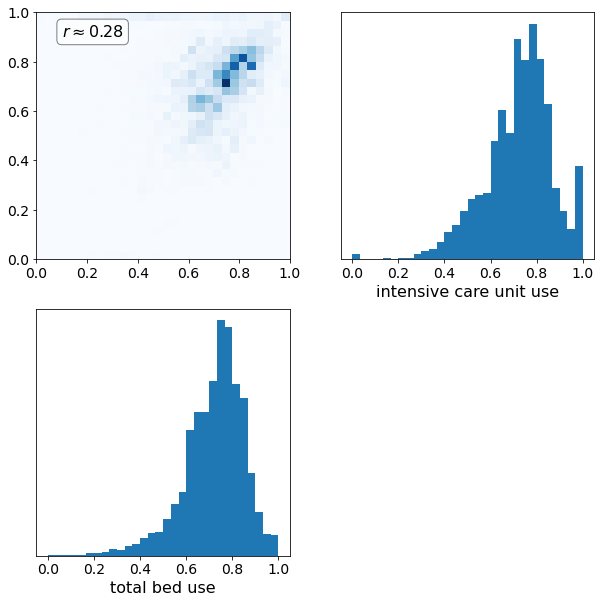

In [242]:
# calculate correlation
r, _ = stats.pearsonr(df.used_bed_ratio, df.used_icu_ratio)

# plot histograms and correlation 
fig, ax = plt.subplots(2,2,figsize = (10,10))

c = ax[0][0].hist2d(df.used_bed_ratio, df.used_icu_ratio, bins = 30, cmap=plt.cm.Blues)
ax[0][0].tick_params(axis='both', which='major', labelsize=14)
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax[0][0].text(0.1, 0.9, r"$r \approx$" + str(round(r, 2)), bbox=props, fontsize = 16)
#fig.colorbar(c[3], ax=ax[0][0])

ax[0][1].hist(df.used_icu_ratio, bins = 30)
ax[0][1].set_xlabel("intensive care unit use", fontsize = 16)
ax[0][1].set_yticklabels([])
ax[0][1].set_yticks([])
ax[0][1].tick_params(axis='x', which='major', labelsize=14)

ax[1][0].hist(df.used_bed_ratio, bins = 30)
ax[1][0].set_xlabel("total bed use", fontsize = 16)
ax[1][0].set_yticklabels([])
ax[1][0].set_yticks([])
ax[1][0].tick_params(axis='x', which='major', labelsize=14)


ax[1][1].axis('off')

plt.show()

# 5. Time Distribution of Dataset

In [243]:
# get number of reported cases for all months
month = df.case_month.unique()
month.sort()

month_count = []
for date in month:
  month_count.append(len(df[df['case_month'] == date]))

In [244]:
# get official case numbers for comparison (sourced from Johns Hopkins CSSE)
# https://data.world/shad/covid-19-time-series-data
df_cases = pd.read_csv('/content/drive/MyDrive/Colab_Projects/AML_final_project/confirmed_global.csv')
df_cases.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,7/13/21,7/14/21,7/15/21,7/16/21,7/17/21,7/18/21,7/19/21,7/20/21,7/21/21,7/22/21,7/23/21,7/24/21,7/25/21,7/26/21,7/27/21,7/28/21,7/29/21,7/30/21,7/31/21,8/1/21,8/2/21,8/3/21,8/4/21,8/5/21,8/6/21,8/7/21,8/8/21,8/9/21,8/10/21,8/11/21,8/12/21,8/13/21,8/14/21,8/15/21,8/16/21,8/17/21,8/18/21,8/19/21,8/20/21,8/21/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,134653,136643,137853,137853,137853,137853,141489,142414,142414,143183,143439,143439,143439,144285,145008,145552,145996,146523,146523,146523,147985,148572,148933,149361,149810,149810,149810,150778,151013,151291,151563,151770,151770,151770,152142,152243,152363,152411,152448,152448
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,132608,132616,132629,132647,132665,132686,132697,132740,132763,132797,132828,132853,132875,132891,132922,132952,132999,133036,133081,133121,133146,133211,133310,133442,133591,133730,133912,133981,134201,134487,134761,135140,135550,135947,136147,136598,137075,137597,138132,138790
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,147883,148797,149906,151103,152210,153309,154486,155784,157005,158213,159563,160868,162155,163660,165204,167131,168668,170189,171392,172564,173922,175229,176724,178013,179216,180356,181376,182368,183347,184191,185042,185902,186655,187258,187968,188663,189384,190078,190656,191171
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,14167,14167,14239,14273,14273,14273,14359,14379,14379,14464,14498,14498,14498,14577,14586,14586,14655,14678,14678,14678,14747,14766,14797,14809,14836,14836,14836,14836,14873,14891,14908,14924,14924,14924,14954,14960,14976,14981,14988,14988
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,40138,40327,40530,40631,40707,40805,40906,41061,41227,41405,41629,41736,41780,41879,42110,42288,42486,42646,42777,42815,42970,43070,43158,43269,43487,43592,43662,43747,43890,43998,44174,44328,44534,44617,44739,44972,45175,45325,45583,45817


In [245]:
df_cases = df_cases[df_cases['Country/Region'] == 'US']
df_cases = df_cases.drop(columns = ['Province/State', 'Country/Region', 'Lat', 'Long'])
df_cases = df_cases.loc[:,'7/1/20':'7/31/21']
df_cases = df_cases.transpose()
df_cases.head()

,254
7/1/20,2694053
7/2/20,2750689
7/3/20,2802040
7/4/20,2847733
7/5/20,2898480


In [246]:
dates = df_cases.index.values
cases = df_cases[254].values

case_diff = cases[1:] - cases[:-1]
dates = dates[1:]

In [247]:

x_values = [datetime.datetime.strptime(d,"%m/%d/%y").date() for d in dates]
x_values = dt.date2num(x_values)

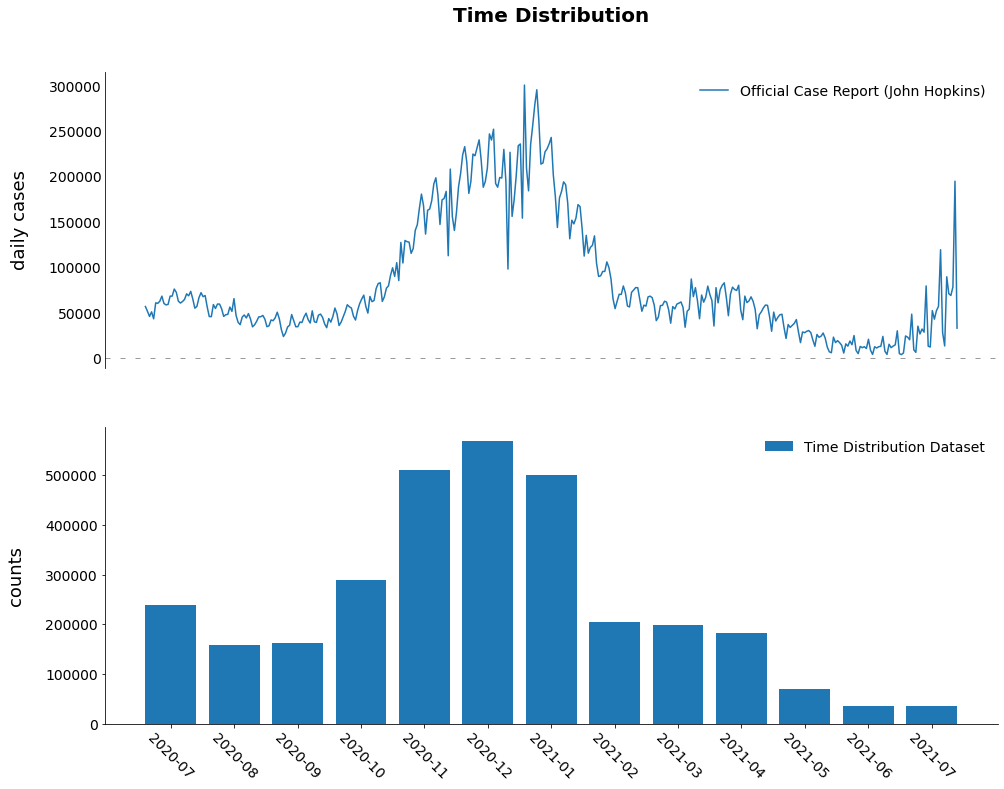

In [248]:
labels = month

x = np.arange(len(labels))  
width = 0.8

fig, ax = plt.subplots(2,figsize=(16,12))

ax[0].plot(x_values, case_diff, label = 'Official Case Report (John Hopkins)')
ax[0].set_title('Time Distribution\n\n', fontsize = 20, fontweight='bold')
ax[0].set_ylabel('daily cases', fontsize = 18, labelpad = 20)
ax[0].tick_params(axis='y', which='major', labelsize=14)
ax[0].legend(frameon = False, fontsize = 14)
ax[0].tick_params(axis=u'both', which=u'both',length=0)
ax[0].set_xticklabels([])
ax[0].axhline(y=0., color='black', linestyle=(0,(5,10)), alpha = 0.4, linewidth = 1)
top_side2 = ax[0].spines["top"]
top_side2.set_visible(False)
right_side2 = ax[0].spines["right"]
right_side2.set_visible(False)
bottom_side2 = ax[0].spines["bottom"]
bottom_side2.set_visible(False)

ax[1].bar(x, month_count, width, label = 'Time Distribution Dataset')
ax[1].set_ylabel('counts', fontsize = 18, labelpad = 20)
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels, fontsize = 16)
ax[1].tick_params(axis='y', which='major', labelsize=14)
ax[1].tick_params(axis='x', which='major', labelsize=14, rotation = -45)
ax[1].legend(frameon = False, fontsize = 14)
top_side = ax[1].spines["top"]
top_side.set_visible(False)
right_side = ax[1].spines["right"]
right_side.set_visible(False)

plt.show()